[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/03.regression_contd-and-classification/b.regularization.ipynb)

We will use the same dataset as in the previous notebook.

In [6]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from math import sqrt
from statistics import mean
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# %pip install regressors
from regressors import stats # To print information about 
                            # regression. 


# Download the code I prepared for you
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

from andrea_models import AndreaLinearRegression # In the course library
from visualization import rotate_labels

--2022-10-17 09:01:45--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.1’

andrea_models.py.1  100%[===================>]   3.12K  --.-KB/s    in 0.002s  

2022-10-17 09:01:45 (1.82 MB/s) - ‘andrea_models.py.1’ saved [3190/3190]

--2022-10-17 09:01:46--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.


In [7]:
# IGNORE THIS
savefigures=False

Download the dataset

In [8]:
dataset_to_use = 'B1'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"

filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name

--2022-10-17 09:01:57--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.B1_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58556 (57K) [text/plain]
Saving to: ‘df.B1_2.csv.1’

df.B1_2.csv.1       100%[===================>]  57.18K  --.-KB/s    in 0.05s   

2022-10-17 09:01:57 (1.12 MB/s) - ‘df.B1_2.csv.1’ saved [58556/58556]



In [9]:
df = pd.read_csv(filename)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 207 columns):
 #    Column               Dtype  
---   ------               -----  
 0    RelativeTime         float64
 1    PacketsSent          int64  
 2    PacketsReceived      int64  
 3    BytesSent            int64  
 4    BytesReceived        int64  
 5    IPSrc0               object 
 6    IPDst0               object 
 7    Protocol0            object 
 8    PacketsSent0         int64  
 9    PacketsReceived0     int64  
 10   BytesSent0           int64  
 11   BytesReceived0       int64  
 12   IPSrc1               object 
 13   IPDst1               object 
 14   Protocol1            object 
 15   PacketsSent1         int64  
 16   PacketsReceived1     int64  
 17   BytesSent1           int64  
 18   BytesReceived1       int64  
 19   IPSrc2               object 
 20   IPDst2               object 
 21   Protocol2            object 
 22   PacketsSent2         int64  
 23   PacketsReceived

In [10]:
df.head()

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,BufferValid,KBytesReceived,label,label_num,KBytesReceived_log,PacketsSent_log,PacketsReceived_log,BytesSent_log,BytesReceived_log,BufferProgress_log
0,4.0,6,31,1668,36199,192.168.1.15,74.125.0.41,QUIC,2,26,...,True,36.199,q360p,360,3.589031,1.945910,3.465736,7.419980,10.496814,0.015240
1,3.8,10,58,1935,77605,192.168.1.15,173.194.31.91,QUIC,5,55,...,True,77.605,q144p,144,4.351632,2.397895,4.077537,7.568379,11.259400,0.007078
2,3.6,14,62,2842,75432,192.168.1.15,173.194.131.41,QUIC,7,54,...,True,75.432,q144p,144,4.323232,2.708050,4.143135,7.952615,11.231000,0.006487
3,3.7,33,205,3569,278065,192.168.1.15,173.194.31.91,QUIC,16,168,...,True,278.065,q360p,360,5.627855,3.526361,5.327876,8.180321,12.535614,0.005879
4,3.6,6,20,2036,27840,192.168.1.15,74.125.0.24,QUIC,4,20,...,True,27.840,q360p,360,3.326474,1.945910,3.044522,7.619233,10.234265,0.007130


Let's try to infer BufferHealth from the following features

In [11]:
features = ['KBytesReceived_log','BytesSent_log', 'PacketsSent', 
            'PacketsReceived', 'BytesSent1']

X = df[features].values
y = df['BufferHealth'].values

We will try different parameters of a model on the training set and evaluate their performance on the test set.

In [12]:
X_train, X_test, y_train, y_test =train_test_split(
    X,y, test_size=0.3, shuffle=True, random_state=7)

### Linear regression

Let's first try a simple linear regression

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_lin = sqrt(mean_squared_error(y_pred, y_test) )
RMSE_lin

2.148766515019232

A regressor with the regularization term is also called Ridge regressor.

First, see that `Ridge` with `alpha=0`, the model becomes a simple linear regression.

In [14]:
# The implementation of Ridge regression does not behave well with
# alpha=0, as it expects alpha > 0
model = Ridge(alpha=1e-13)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )

2.148766515019224

### Linear regression + regularization

Let's try with some `alpha > 0`

In [15]:
model = Ridge(alpha=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )


2.1476270838437523

Find the best alpha in the training set and report the cross validation error. 

**When looking for the best parameter, use training data only** (otherwise you have **data leakage**).

,alphas,cross-validation errors
0,1e-09,3.013704
1,0.5,2.961386
2,1,2.925507
3,10,2.783285
4,100,2.738127
5,1000,2.710322
6,10000,2.672646
7,100000.0,2.662294
8,1000000.0,2.860985


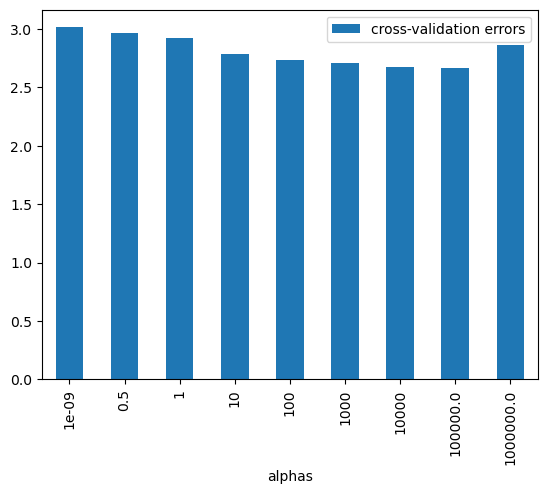

In [16]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

alphas = [1e-9, 0.5, 1, 10, 100, 1000, 10000, 1e5, 1e6]
errors = []
for a in alphas:
    scores = cross_val_score(Ridge(alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
# We convert x-values to string because otherwise they would 
# be to far from each other
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'cross-validation errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

Let's analyze the best Ridge regression model.

In [17]:
model = Ridge(alpha=100000)
model.fit(X_train, y_train)
stats.summary(model, X_train, y_train)

Residuals:
    Min      1Q  Median     3Q    Max
-5.8009 -0.2072  0.7453 1.3316 3.4802


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept  4.098252   12.370681   0.3313  0.742656
x1         -0.000007    1.034499  -0.0000  0.999995
x2          0.000019    0.548456   0.0000  0.999973
x3          0.001179    0.047631   0.0247  0.980417
x4          0.011015    0.002133   5.1634  0.000013
x5         -0.000267    0.002675  -0.1000  0.921024
---
R-squared:  0.42290,    Adjusted R-squared:  0.31192
F-statistic: 3.81 on 5 features


In [18]:
y_pred = model.predict(X_test)
RMSE_lin_ridge = sqrt(mean_squared_error(y_pred, y_test) )
RMSE_lin_ridge

2.1019796958771435

We improved the model.

Can we improve it further by exploting some non-linear dependency?

# Polynomial regression and regularization

Let's try a polynomial regression

In [27]:
def MyPolynomialRegression(degree=2, include_bias=False):
     return make_pipeline(PolynomialFeatures(degree=degree, include_bias=include_bias), LinearRegression())


model = MyPolynomialRegression(degree=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_quadr = sqrt(mean_squared_error(y_pred, y_test) )
print("RMSE quadr: ", RMSE_quadr, "RMSE Ridge: ", RMSE_lin)

RMSE quadr:  3.162059124548073 RMSE Ridge:  2.148766515019232


Clearly, **overfitting**.

Let's modify `MyPolynomialRegression` in order to perform ridge regression instead of simple linear regression in the last step.

In [33]:
def MyPolynomialRegression(degree=2, include_bias=False, alpha=1e-9):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=include_bias), Ridge(alpha=alpha) )

,alphas,errors
0,0.5,6.518287
1,1,6.373724
2,10,5.657535
3,100,5.003791
4,1000,4.582287
5,100000.0,3.796534
6,1000000.0,3.303027
7,10000000.0,2.930702
8,1000000000.0,2.669323
9,1000000000000.0,3.048577


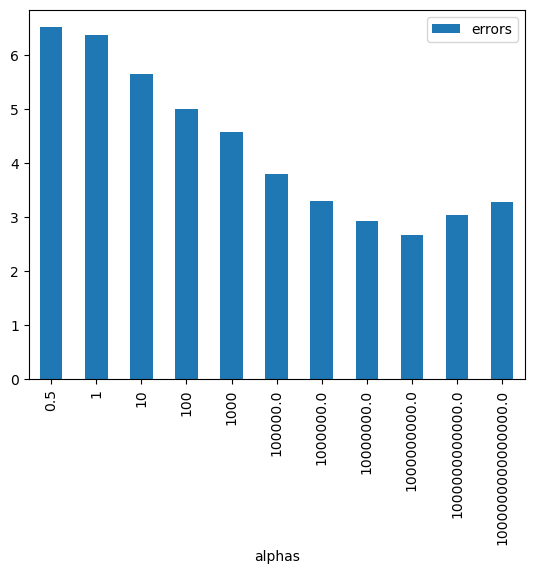

In [34]:
alphas = [0.5, 1, 10, 100, 1000, 1e5, 1e6, 1e7, 1e9, 1e12, 1e15]
errors = []
for a in alphas:
    scores = cross_val_score(MyPolynomialRegression(degree=2,
                    include_bias=False, alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

Let's compute the test error for the best alpha

In [35]:
model = MyPolynomialRegression(degree=2, alpha=1e9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_poly_and_ridge = sqrt(mean_squared_error(y_pred, y_test) )
print("RMSE_poly_and_ridge: ", RMSE_poly_and_ridge,
      "\nRMSE poly without ridge: ", RMSE_quadr,
      "\nRMSE linear: ", RMSE_lin)

RMSE_poly_and_ridge:  2.022860936212547 
RMSE poly without ridge:  3.162059124548073 
RMSE linear:  2.148766515019232


Regularization improved the model

# Feature scaling

Go back to slides

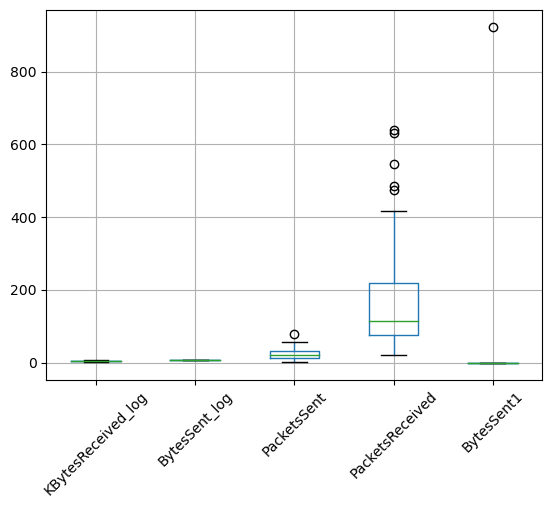

In [36]:
ax = df[features].boxplot()
ax.tick_params(axis='x', labelrotation=45)


The scale of the features is very diverse. Our regularized model is likely to ignore the "smallest" features.

In [37]:
# IGNORE THIS
if savefigures:
  from google.colab import drive
  mount_point = '/content/gdrive'
  drive.mount(mount_point, force_remount=True)
  drive_path = mount_point+'/My Drive/'
  my_path = drive_path + 'tsp/teaching/data-science-for-networks/img-from-code/02.regression/'

  plt.savefig(my_path+'c.boxplot.pdf')

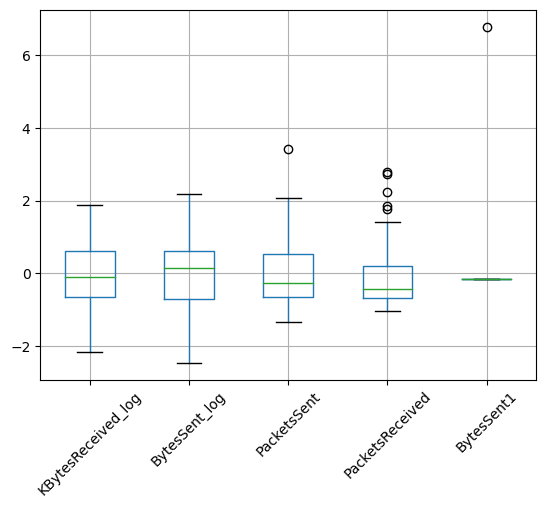

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled)
df_scaled.columns = features
ax = df_scaled.boxplot()
ax.tick_params(axis='x', labelrotation=45)

if savefigures:
  plt.savefig(my_path+'c.boxplot-scaled.pdf')

Scaling is usually included in the pipelines. Pipelines will follow the correct protocol when scaling. For instance, if we use a Max-Min Scaler, the pipeline defined in the following code will behave as follows:
* When you call `fit` on your pipeline (and you pass `X_train`,`y_train`), the pipeline will compute the Min and the Max of the features of `X_train`, scale `X_train`  accordingly and also storing these standard deviations for later use
* It will then train the model on the scaled dataset
* When you call `predict` on your pipeline (and you pass `X_test`), the pipeline will scale each sample based on the Min and the Max **computed before**
* The pipeline will make the prediction

Note the scaling parameters (e.g., the Min and the Max) are calculated only based on the training set.

Let's construct a pipeline with scaling and Ridge regression.

In [39]:
def MyScalingAndPolyRidge(degree=2, alpha=2):
    return make_pipeline(
       PolynomialFeatures(degree=degree, include_bias=False),
        MinMaxScaler(),
        Ridge(alpha=alpha)
    )

Let's find the best alpha with GridSearch

,alphas,errors
0,1e-09,6.923786
1,1e-07,6.902089
2,0.0001,5.156224
3,0.001,4.019781
4,0.1,2.976582
5,0.2,3.010931
6,0.5,2.996951
7,1,2.952820
8,10,2.848838
9,100,3.125481


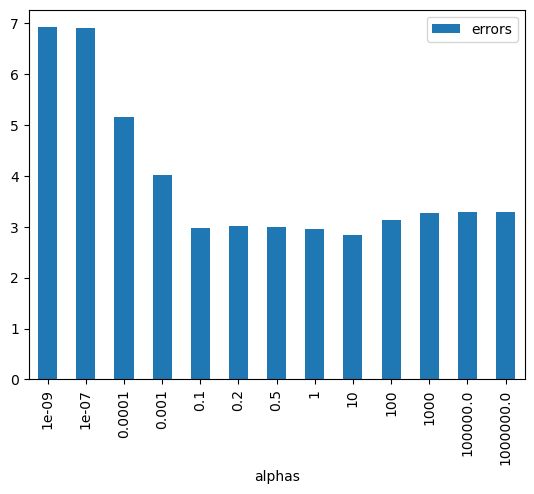

In [40]:
alphas = [1e-9, 1e-7, 1e-4, 1e-3, 0.1, 0.2, 0.5, 1, 10, 100, 1000, 1e5, 1e6]
errors = []
for a in alphas:
    scores = cross_val_score(MyScalingAndPolyRidge(degree=2,
                    alpha=a), 
                X_train, y_train, cv=k_fold, 
                scoring = 'neg_mean_squared_error')
    errors.append(sqrt(mean(-scores) ) )
    
df_errors = pd.DataFrame({'alphas':[str(a) for a in alphas],
                        'errors':errors})
ax = df_errors.plot.bar(x='alphas')
df_errors

After scaling, the best $\alpha$ is 10.

In [41]:
model = MyScalingAndPolyRidge(degree=2,
                    alpha=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_scaling_and_poly_and_ridge = \
    sqrt(mean_squared_error(y_pred, y_test) )
    
print("RMSE_scaling_and_poly_and_ridge: ",
      RMSE_scaling_and_poly_and_ridge,
      "\nRMSE_poly_and_ridge:", 
      RMSE_poly_and_ridge)

RMSE_scaling_and_poly_and_ridge:  2.0676087427733334 
RMSE_poly_and_ridge: 2.022860936212547


Scaling improved the accuracy.

# Grid search

Let's find the best combination of polynomial degree and regularization weight.

Let's check how parameters are called

In [42]:
GridSearchCV(MyScalingAndPolyRidge(), []).get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__polynomialfeatures', 'estimator__minmaxscaler', 'estimator__ridge', 'estimator__polynomialfeatures__degree', 'estimator__polynomialfeatures__include_bias', 'estimator__polynomialfeatures__interaction_only', 'estimator__polynomialfeatures__order', 'estimator__minmaxscaler__clip', 'estimator__minmaxscaler__copy', 'estimator__minmaxscaler__feature_range', 'estimator__ridge__alpha', 'estimator__ridge__copy_X', 'estimator__ridge__fit_intercept', 'estimator__ridge__max_iter', 'estimator__ridge__normalize', 'estimator__ridge__positive', 'estimator__ridge__random_state', 'estimator__ridge__solver', 'estimator__ridge__tol', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [43]:
parameters_to_test=[{'ridge__alpha':[0.1, 0.2, 0.5, 1, 5, 10, 50, 
                             1e6],
                     'polynomialfeatures__degree':np.arange(1,6)
                    }]
grid = GridSearchCV(MyScalingAndPolyRidge(), parameters_to_test,
                    cv=k_fold, scoring='neg_mean_squared_error'
    )

In [44]:
grid.fit(X_train, y_train)
print("The best parameters are", grid.best_params_)

The best parameters are {'polynomialfeatures__degree': 1, 'ridge__alpha': 1}


Let's validate on the test set

In [45]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
RMSE_grid = sqrt(mean_squared_error(y_pred, y_test))

RMSE_grid

2.1230407209367157

# Recursive Feature Elimination

We now experiment with Recursive Feature Elimination with Linear Regression

In [46]:
def MyScaledLinearRegression():
    return make_pipeline(
        StandardScaler(),
        LinearRegression()
        )

The following code will lead to a **known error**

In [47]:
# The following code will lead to a known error

rfe = RFECV(MyScaledLinearRegression())
rfe.fit(X_train, y_train)

ValueError: when `importance_getter=='auto'`, the underlying estimator Pipeline should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

We need to modify the `Pipeline` class (inspired by [this blog](https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/) and this [StackOverflow post](https://stackoverflow.com/q/36683230/2110769))

In [48]:
class MyPipeline(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(MyPipeline, self).fit(X, y, **fit_params)
        self.coef_ = self.steps[-1][-1].coef_
        return self

Let's try again

In [49]:
def MyScaledLinearRegression():
    return MyPipeline(
        [ 
            ('my_nice_scaler',StandardScaler() ), 
            ('my_beautiful_regression', LinearRegression() )
        ]
    )

rfe = RFECV(MyScaledLinearRegression(), cv=k_fold, 
            scoring='neg_mean_squared_error')
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
      estimator=MyPipeline(steps=[('my_nice_scaler', StandardScaler()),
                                  ('my_beautiful_regression',
                                   LinearRegression())]),
      scoring='neg_mean_squared_error')

Let's check how the cross-validated error changed with the num of features

In [50]:
RMSE_values = np.sqrt(- rfe.grid_scores_)
RMSE_values

/home/aung/anaconda3/envs/Tensorflow/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[3.58979187, 1.52215781, 2.85707772, 1.49733009, 3.12317536],
       [4.15669923, 1.83212377, 2.68550812, 1.45802374, 3.25148639],
       [4.17578144, 2.45531552, 2.73615919, 1.48070552, 3.28360494],
       [4.1840351 , 2.66045989, 2.77515232, 1.50719225, 3.29143878],
       [4.1840351 , 2.66474817, 2.7740062 , 1.50638706, 3.29252461]])

Let's plot the cross-validation error vs. number of features

[Text(0, 0.5, 'Cross-Val RMSE'), Text(0.5, 0, 'Num of features')]

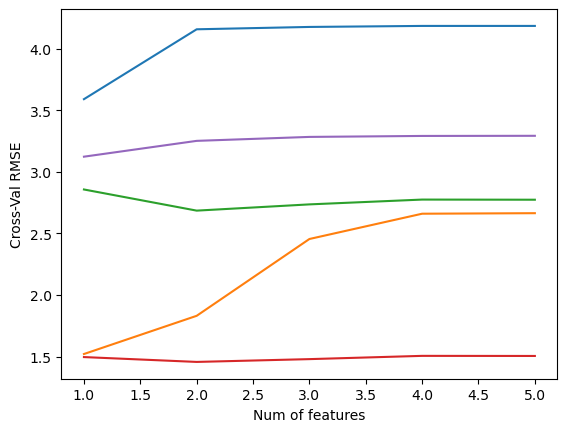

In [51]:
num_of_features = np.arange(1,len(features)+1)

fig, ax = plt.subplots()
ax.plot(num_of_features, RMSE_values)
ax.set(xlabel="Num of features", ylabel="Cross-Val RMSE")

One feature only seems to give the best model. What is such feature?

In [52]:
all_features_array = np.array(features)
selected_features = all_features_array[rfe.support_]
selected_features

array(['PacketsReceived'], dtype='<U18')

Let's test the selected model

In [53]:
y_pred = rfe.predict(X_test)
RMSE_feat_elimin = sqrt(mean_squared_error(y_pred, y_test))
print('RMSE_feat_elimin:', RMSE_feat_elimin, 
      '\nRMSE with scaling, poly degree 2 and alpha=10: ', 
      RMSE_scaling_and_poly_and_ridge,
     '\nRMSE_lin:', RMSE_lin)

RMSE_feat_elimin: 2.1444712038430045 
RMSE with scaling, poly degree 2 and alpha=10:  2.0676087427733334 
RMSE_lin: 2.148766515019232


This model is better than the linear regression where we had all the features. 

However, the model with scaling, degree 2 and alpha=10 is the best.

Some idea to improve even more the model?

<details>
<summary>...
    
__Click__
</summary>

* Find the best polynomial + normalization model based only on these two features. Or
* Use RFECV on the polynomial model to select a subset of transformed features. Or
* 
</details>